## Train Model

In [1]:
import os
import logging
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()

### Train Callback

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [3]:
env_name = 'SW2DDynGoal'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

log_path = os.path.join('Training', 'Logs')

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    tensorboard_log=log_path,
    learning_rate=0.0001,
    n_steps =2048
    )
logger.setLevel(logging.INFO)

model.learn(
    total_timesteps=300_000, 
    callback = callback
    )

model.save('PPO')

logger.setLevel(logging.DEBUG)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training/Logs/PPO_38
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 16.2      |
|    ep_rew_mean     | -2.37e+03 |
| time/              |           |
|    fps             | 858       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 17.6         |
|    ep_rew_mean          | -2.6e+03     |
| time/                   |              |
|    fps                  | 833          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0015497096 |
|    clip_fraction        | 0.000586     |
|    cl

## Test Model

In [4]:
from stable_baselines3 import PPO
from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()

model = PPO.load("PPO", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.0423097610473633
DEBUG:root:movement: 1.3970947265625
DEBUG:root:vector 1: [-1.         -0.30067444]
DEBUG:root:vector 2: [-1.         -0.08792305]
DEBUG:root:angle: 0.20437792580749284
DEBUG:root:movement: 1.2609610557556152
DEBUG:root:vector 1: [-1.         -0.08792305]
DEBUG:root:vector 2: [-1.          0.24552059]
DEBUG:root:angle: 0.3284557852748075
DEBUG:root:movement: 1.6608400344848633
DEBUG:root:vector 1: [-1.          0.24552059]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 1.0261565305131037
DEBUG:root:movement: 1.6389212608337402
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.542978048324585
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1.        -0.7119131]
DEBUG:root:angle: 0.1667216299257611
DEBUG:root:movement: 1.3736624717712402
DEBUG:root:vector 1: [-1.        -0.7119131]
DEBUG:root:vector 2: [-1.         -0.03986073]
DEBUG:root

done
info {'distance_to_goal': 0.8674809, 'steps_taken': 9, 'previous_state': array([ 9.490047 , 10.283653 ,  9.101475 , 10.2777815,  8.646529 ,
       10.418431 ], dtype=float32), 'new_state': array([ 9.490047 , 10.283653 ,  9.101475 , 10.2777815,  8.646529 ,
       10.418431 ], dtype=float32)}


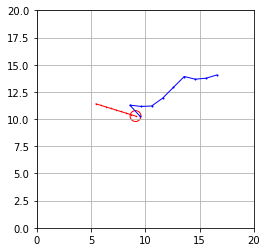

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.4139444828033447
DEBUG:root:movement: 1.7231311798095703
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:reached goal
DEBUG:root:x: [8.297686, 9.297686, 10.297686, 11.035519]
DEBUG:root:y: [13.384495, 12.384495, 11.384495, 10.384495]
DEBUG:root:goal: [10.802588 10.017843]


done
info {'distance_to_goal': 1.6736887, 'steps_taken': 3, 'previous_state': array([11.035519, 10.384495, 10.802588, 10.017843, 11.278662, 10.028427],
      dtype=float32), 'new_state': array([11.035519, 10.384495, 10.802588, 10.017843, 11.278662, 10.028427],
      dtype=float32)}


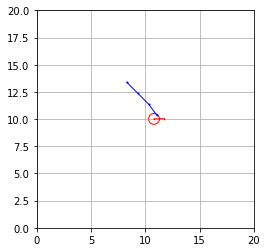

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.3372373580932617
DEBUG:root:movement: 1.6372718811035156
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5169224739074707
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.2938814163208008
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.9872656 1.       ]
DEBUG:root:angle: 0.006403759500809684
DEBUG:root:movement: 1.144507884979248
DEBUG:root:vector 1: [0.9872656 1.       ]
DEBUG:root:vector 2: [-0.03535271  1.        ]
DEBUG:root:angle: 0.8143281782260873
DEBUG:root:movement: 1.2285358905792236
DEBUG:root:vector 1: [-0.03535271  1.        ]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.7500601762524602
DEBUG:root:movement: 1.0632810592651367
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [0.1872139 0.9999995]
DEBUG:root:angle: 0.9704698430605221
DEBUG:root:movement: 1.296422481

done
info {'distance_to_goal': 0.8033186, 'steps_taken': 12, 'previous_state': array([8.501837, 9.614095, 8.271581, 9.27243 , 8.710471, 9.45718 ],
      dtype=float32), 'new_state': array([8.501837, 9.614095, 8.271581, 9.27243 , 8.710471, 9.45718 ],
      dtype=float32)}


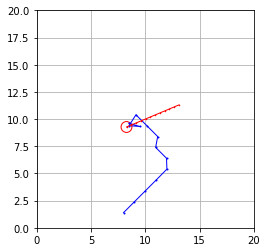

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.1376466751098633
DEBUG:root:movement: 1.4374775886535645
DEBUG:root:vector 1: [1.        1.0000005]
DEBUG:root:vector 2: [0.00386429 1.        ]
DEBUG:root:angle: 0.7815335924589256
DEBUG:root:movement: 1.449193000793457
DEBUG:root:vector 1: [0.00386429 1.        ]
DEBUG:root:vector 2: [0.2922001 1.       ]
DEBUG:root:angle: 0.28042106251197635
DEBUG:root:movement: 1.372459888458252
DEBUG:root:vector 1: [0.2922001 1.       ]
DEBUG:root:vector 2: [0.53069115 1.        ]
DEBUG:root:angle: 0.20361235759122095
DEBUG:root:movement: 1.4704759120941162
DEBUG:root:vector 1: [0.53069115 1.        ]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 1.2732961815926636
DEBUG:root:movement: 1.4203604459762573
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-0.20240021  1.        ]
DEBUG:root:angle: 0.5856957152349109
DEBUG:root:movement: 0.3262861967086792
DEBUG:root:vector 1: [-0.20240021  1.        ]
DEBUG:root:vector 2: [-0.946085  1.      

done
info {'distance_to_goal': 0.8751092, 'steps_taken': 8, 'previous_state': array([12.240746, 13.845416, 11.866606, 13.598743, 12.085859, 14.021456],
      dtype=float32), 'new_state': array([12.240746, 13.845416, 11.866606, 13.598743, 12.085859, 14.021456],
      dtype=float32)}


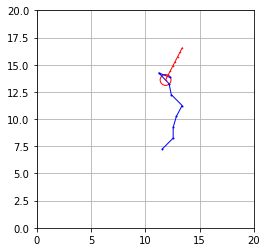

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.1872482299804688
DEBUG:root:movement: 1.4775276184082031
DEBUG:root:vector 1: [0.78393364 1.        ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.12053154619950812
DEBUG:root:movement: 1.2889642715454102
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.44037247 1.        ]
DEBUG:root:angle: 0.3705793132044751
DEBUG:root:movement: 1.2160577774047852
DEBUG:root:vector 1: [0.44037247 1.        ]
DEBUG:root:vector 2: [0.49021912 1.        ]
DEBUG:root:angle: 0.04097341654022711
DEBUG:root:movement: 1.1834321022033691
DEBUG:root:vector 1: [0.49021912 1.        ]
DEBUG:root:vector 2: [-0.7252321  1.       ]
DEBUG:root:angle: 1.0832526653138839
DEBUG:root:movement: 1.1357064247131348
DEBUG:root:vector 1: [-0.7252321  1.       ]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.1579378907157533
DEBUG:root:movement: 1.0249755382537842
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-0.99422264  1.        ]
DEBUG:root:angle: 0.00

done
info {'distance_to_goal': 1.4691333, 'steps_taken': 10, 'previous_state': array([12.904032, 11.055485, 12.676455, 11.11269 , 13.11616 , 11.295489],
      dtype=float32), 'new_state': array([12.904032, 11.055485, 12.676455, 11.11269 , 13.11616 , 11.295489],
      dtype=float32)}


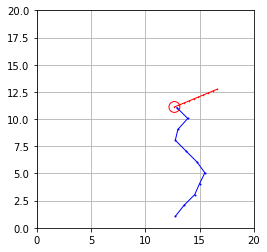

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2643013000488281
DEBUG:root:movement: 1.3158650398254395
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.2993378639221191
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-0.9633894 -1.       ]
DEBUG:root:angle: 0.018644687137035543
DEBUG:root:movement: 1.2879300117492676
DEBUG:root:vector 1: [-0.9633894 -1.       ]
DEBUG:root:vector 2: [-0.964139 -1.      ]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.2656025886535645
DEBUG:root:vector 1: [-0.964139 -1.      ]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.01825701048672918
DEBUG:root:movement: 1.201341152191162
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-0.40657806 -1.        ]
DEBUG:root:angle: 0.3992341935088624
DEBUG:root:movement: 1.1624724864959717
DEBUG:root:vector 1: [-0.40657806 -1.        ]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.3992341935088624
DEBUG

done
info {'distance_to_goal': 0.7342672, 'steps_taken': 12, 'previous_state': array([ 7.9159966, 11.152771 ,  8.042808 , 10.944279 ,  8.471691 ,
       10.737357 ], dtype=float32), 'new_state': array([ 7.9159966, 11.152771 ,  8.042808 , 10.944279 ,  8.471691 ,
       10.737357 ], dtype=float32)}


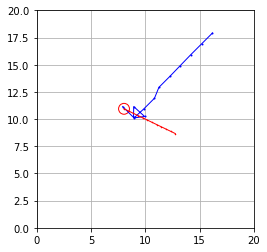

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.4048919677734375
DEBUG:root:movement: 1.477027416229248
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.         1.0000002]
DEBUG:root:angle: 0.0004882812548506386
DEBUG:root:movement: 1.3622503280639648
DEBUG:root:vector 1: [-1.         1.0000002]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0004882812548506386
DEBUG:root:movement: 1.0023515224456787
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-0.3383131  1.       ]
DEBUG:root:angle: 0.4591727080553951
DEBUG:root:movement: 0.8583245277404785
DEBUG:root:vector 1: [-0.3383131  1.       ]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.4591727080553951
DEBUG:root:movement: 0.8327921628952026
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [0.67530346 1.        ]
DEBUG:root:angle: 1.3793563030639029
DEBUG:root:movement: 0.7934321165084839
DEBUG:root:vector 1: [0.67530346 1.        ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.19144044086304463
DEBUG:roo

done
info {'distance_to_goal': 0.72330976, 'steps_taken': 10, 'previous_state': array([12.622255 , 11.6077385, 12.734585 , 11.252668 , 12.301656 ,
       11.054351 ], dtype=float32), 'new_state': array([12.622255 , 11.6077385, 12.734585 , 11.252668 , 12.301656 ,
       11.054351 ], dtype=float32)}


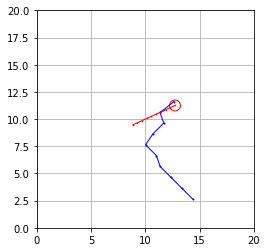

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.410736083984375
DEBUG:root:movement: 0.9330606460571289
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9306421279907227
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9269328117370605
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9208340644836426
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9097850322723389
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.8867404460906982
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.8270825147628784
DEBUG:root:vector 1: [-1.  1.]
DEBUG:roo

done
info {'distance_to_goal': 1.0733917, 'steps_taken': 10, 'previous_state': array([ 9.561377 , 10.976474 ,  9.175463 , 10.686062 ,  9.5415125,
       10.381489 ], dtype=float32), 'new_state': array([ 9.561377 , 10.976474 ,  9.175463 , 10.686062 ,  9.5415125,
       10.381489 ], dtype=float32)}


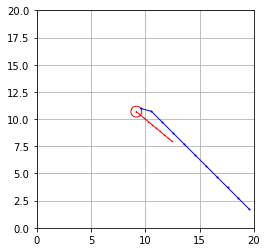

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2410917282104492
DEBUG:root:movement: 1.6502084732055664
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5087127685546875
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1.         0.37337685]
DEBUG:root:angle: 0.4280512754936905
DEBUG:root:movement: 1.5100631713867188
DEBUG:root:vector 1: [1.         0.37337685]
DEBUG:root:vector 2: [1.         0.38159227]
DEBUG:root:angle: 0.007184555964608718
DEBUG:root:movement: 1.4713115692138672
DEBUG:root:vector 1: [1.         0.38159227]
DEBUG:root:vector 2: [1.         0.18385792]
DEBUG:root:angle: 0.18271057027829327
DEBUG:root:movement: 1.5763623714447021
DEBUG:root:vector 1: [1.         0.18385792]
DEBUG:root:vector 2: [1.       0.841486]
DEBUG:root:angle: 0.5177030965306251
DEBUG:root:movement: 1.4303785562515259
DEBUG:root:vector 1: [1.       0.841486]
DEBUG:root:vector 2: [ 1.         -0.14593315]
DEBUG:root:ang

done
info {'distance_to_goal': 1.8620411, 'steps_taken': 8, 'previous_state': array([13.317191,  9.792649, 13.653137,  9.625419, 14.126844,  9.576847],
      dtype=float32), 'new_state': array([13.317191,  9.792649, 13.653137,  9.625419, 14.126844,  9.576847],
      dtype=float32)}


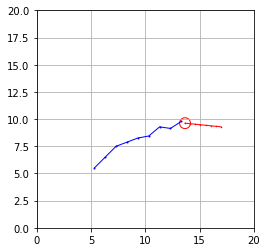

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.18735933303833
DEBUG:root:movement: 1.3840537071228027
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 0.836545 -1.      ]
DEBUG:root:angle: 0.08876880247359437
DEBUG:root:movement: 1.3629803657531738
DEBUG:root:vector 1: [ 0.836545 -1.      ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.08876880247359437
DEBUG:root:movement: 1.2543752193450928
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [-0.37037706 -1.        ]
DEBUG:root:angle: 1.140109689965611
DEBUG:root:movement: 1.405308485031128
DEBUG:root:vector 1: [-0.37037706 -1.        ]
DEBUG:root:vector 2: [ 0.9999995 -1.       ]
DEBUG:root:angle: 1.1401094603837678
DEBUG:root:reached goal
DEBUG:root:x: [5.0738716, 6.0738716, 6.9104166, 7.9104166, 7.5400395, 8.540039, 8.954104]
DEBUG:root:y: [15.211438, 14.211438, 13.211438, 12.211438, 11.211438, 10.211438, 9.211438]
DEBUG:root:goal: [8.8969965 8.941246 ]


done
info {'distance_to_goal': 1.6000042, 'steps_taken': 6, 'previous_state': array([8.954104 , 9.211438 , 8.8969965, 8.941246 , 8.553458 , 8.61149  ],
      dtype=float32), 'new_state': array([8.954104 , 9.211438 , 8.8969965, 8.941246 , 8.553458 , 8.61149  ],
      dtype=float32)}


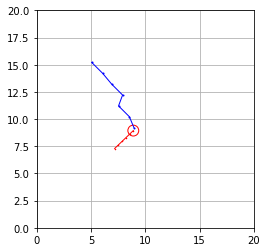

In [5]:

# test prediction
logger.setLevel(logging.DEBUG)

episodes = 10
for episode in range(episodes):
    env.reset()

    while True:
        action, _states = model.predict(env.state)
        obs, rewards, done, info = env.step(action)
        if done:
            print('done')
            print("info", info)
            break
    env.render()

In [6]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env, n_eval_episodes=10, render=False)

# TODO render doesn't work

/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2178020477294922
DEBUG:root:movement: 1.3744335174560547
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.99999976 1.        ]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.3358097076416016
DEBUG:root:vector 1: [0.99999976 1.        ]
DEBUG:root:vector 2: [1.        0.8427439]
DEBUG:root:angle: 0.08513244154360436
DEBUG:root:movement: 1.3114986419677734
DEBUG:root:vector 1: [1.        0.8427439]
DEBUG:root:vector 2: [1.        0.7163582]
DEBUG:root:angle: 0.07864567807252018
DEBUG:root:movement: 1.2971367835998535
DEBUG:root:vector 1: [1.       

(1045.589216291532, 84.10967097010041)